# Model Training Pipeline with Keras

Here we show how to build pipelines to train a Keras (Tensorflow backend) models with a GPU. 

## Simple Pipeline

First we'll look at a simple pipeline with only two pipe segments, a loader and trainer, useful for training with large data sets that can't fit in memory. We'll first write a generator function that generates fake data. Of course in real applications this function would read data from disk or S3 etc. 

In [1]:
import numpy as np

# Generate fake data
# Each iteration emulates a file loaded from disk
def gen_fake_data(n_files, rows_per_file, n_cols=32, eps=0.1):
    for _ in range(n_files):
        
        # Generate random features drawn from a standard normal distribution 
        X = np.random.randn(rows_per_file, n_cols)
        
        # Generate binary targets as a non-trivial function of features 
        maximum = X.max(1) - 2.0 # Max of all features less 2 sigma
        interactions = (X*np.flip(X,1)).mean(1) # Pairwise interaction of mirror columns  
        noise = eps*np.random.randn(rows_per_file) # small amount of random noise 
        y = (maximum + interactions + noise >= 0).astype(np.int32)
        
        yield (X, y)

Usually we'd want to do some preprocessing on our data to make sure it's properly normalized etc. However, since all the features are sampled from a standard normal we don't have to worry about that here. 

Now we can define the trainer functor. We'll want to save the model once the pipeline is finished running so we'll use a class functor with a `local_term` method. Typically When using a GPU you will need to define the model on the local/child process. So lets also create a function to build our keras model and run in it `local_init`. 

In [3]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

#suppress tf warnings 
tf.logging.set_verbosity(tf.logging.ERROR)

def build_model(hidden_arch):
    
    # Ask Tensorflow to use only as much GPU memory as needed
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    tf.Session(config=config)
    
    # Build model on local process
    model = Sequential()
    first_layer_output = hidden_arch.pop(0) 
    model.add(Dense(first_layer_output, input_shape=(32,), activation='relu'))
    for output_size in hidden_arch:
        model.add(Dense(output_size, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    # Return complied model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Keras Trainer class
# This class will train a model via keras' model.fit 
class train_keras:
    
    def __init__(self, hidden_arch, batch_size, save_name):
        self.batch_size = batch_size
        self.save_name = save_name
        self.hidden_arch = hidden_arch
        
    def local_init(self):
        self.model = build_model(self.hidden_arch)
        print('Model Summary')
        self.model.summary()
        print()
        
    def run(self, data):
        X, y = data
        self.model.fit(X, y, epochs=1, batch_size=self.batch_size)
        
    def local_term(self):
        print("Saving model to {}".format(self.save_name))
        self.model.save(self.save_name)

We set the session config and build the model in `local_init` so that the graph is built on the local process and not the main process, since Keras is not thread safe. Additionally we save the model in `local_term` so the model is not lost once the pipe segment and process is terminated. However, `__init__` should be run on the main process before you start the pipeline. 

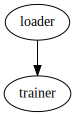

In [4]:
import minipipe as mp

# Init generator (optional) and class functors
loader = gen_fake_data(n_files=10, rows_per_file=32*1000)

trainer = train_keras(hidden_arch = [64, 16], 
                     batch_size=32, 
                     save_name='keras_model.hdf5')

# Build and display pipeline
pline = mp.PipeLine()
pline.add(mp.Source(loader, name='loader'))
pline.add(mp.Sink(trainer, name='trainer'))
pline.build(log_lvl='ERROR') # Suppress stream info
pline.diagram()

In [5]:
#run pipeline
pline.run()
pline.close()

Model Summary
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 3,169
Trainable params: 3,169
Non-trainable params: 0
_________________________________________________________________

Epoch 1/1
32000/32000 [==============================] - 5s 160us/step - loss: 0.6404 - acc: 0.6250
Epoch 1/1
32000/32000 [==============================] - 4s 140us/step - loss: 0.5779 - acc: 0.6926
Epoch 1/1
32000/32000 [==============================] - 4s 139us/step - loss: 0.5367 - acc: 0.7255
Epoch 1/1
32000/32000 [==============================] - 5s 142us/step - loss: 0.5221 - a

## Evaluation while Training

Keras can track some metrics during training, such as log loss and accuracy. However, these metrics are all calulated on the training set. Furthermore, more sophisticated metrics such as AUC cannot be calcualted during training with Keras. In this section we'll show how you can perform evalution of AUC on a test/validaton set in parallel with training. 

The easiest way to do this is to persist a model at each step in `train_keras` and have a downstream pipe segment load that model and perform evaluation. We'll have to modify our `train_keras` class so it can be used as a transform and define a evalution sink. 

In [6]:
from keras.models import load_model
from sklearn.metrics import roc_auc_score as auc
import matplotlib.pyplot as plt
import time
%matplotlib inline

# Keras Trainer class
# This class will train a model via keras' model.fit 
class train_keras:
    
    def __init__(self, hidden_arch, batch_size, save_name):
        self.batch_size = batch_size
        self.save_name = save_name
        self.hidden_arch = hidden_arch
        
    def local_init(self):
        self.model = build_model(self.hidden_arch)
     
    def run(self, data):
        X, y = data
        self.model.fit(X, y, epochs=1, batch_size=self.batch_size, verbose=0) # Suppress progress bar
        
        # Since eval_keras loads this file it may be locked if eval_keras is reading it
        # Wait and try again later 
        while True:
            try:
                self.model.save(self.save_name)
                break
            except OSError:
                time.sleep(0.1)
                continue
        
        # The only purpose of this output is to tell eval_keras when to execute
        return True

class eval_keras:
    
    def __init__(self, X_test, y_test, batch_size, file_name):
        self.batch_size = batch_size
        self.X_test = X_test
        self.y_test = y_test
        self.file_name = file_name
        
    def local_init(self):
        self.aucs = []
        self.epoch = 0
        
        # Ask Tensorflow to use only as much GPU memory as needed
        config = tf.ConfigProto()
        config.gpu_options.allow_growth=True
        tf.Session(config=config)
        
    def run(self, _):
        # Load model from disk and get predictions from test set 
        self.model = load_model(self.file_name)
        p = self.model.predict(X_test, batch_size=self.batch_size, verbose=0) # Suppress progress bar
        
        # Calculate AUC and print results 
        test_auc = auc(y_test, p)
        print('Epoch {0}: AUC = {1:0.4f}'.format(self.epoch, test_auc))
        
        # Advance epoch and save test_auc for plotting later
        self.epoch += 1
        self.aucs.append(test_auc)
        
    def local_term(self):
        # Plots AUC as a function of step after pipeline has completed
        plt.plot(range(self.epoch), self.aucs, label='AUC')
        plt.xlabel('step')
        plt.ylabel('AUC')
        plt.show()

We've suppressed the Keras training and prediction progress bars with `verbose=0`. Otherwise our print outs can get jumbled with them, makeing the output hard to read. Now we can build a pipeline with our three pipe segments: load, train, eval. 

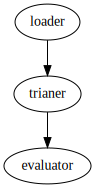

In [7]:
# Init generator (optional) and class functors
loader = gen_fake_data(n_files=10, rows_per_file=32*1000)

trainer = train_keras(hidden_arch = [64, 16], 
                     batch_size=32, 
                     save_name='keras_model.hdf5')

# Generate a test set for the evaluator to use
X_test, y_test = next(gen_fake_data(n_files=1, rows_per_file=32*1000))
evaluator = eval_keras(X_test, y_test, batch_size=128, file_name = 'keras_model.hdf5')

# Build and display pipeline
pline2 = mp.PipeLine()
pline2.add(mp.Source(loader, name='loader'))
pline2.add(mp.Transform(trainer, name='trianer'))
pline2.add(mp.Sink(evaluator, name='evaluator'))
pline2.build(log_lvl='ERROR') # Suppress stream info
pline2.diagram()

Epoch 0: AUC = 0.7290
Epoch 1: AUC = 0.7969
Epoch 2: AUC = 0.8134
Epoch 3: AUC = 0.8164
Epoch 4: AUC = 0.8224
Epoch 5: AUC = 0.8242
Epoch 6: AUC = 0.8266
Epoch 7: AUC = 0.8288
Epoch 8: AUC = 0.8341
Epoch 9: AUC = 0.8345


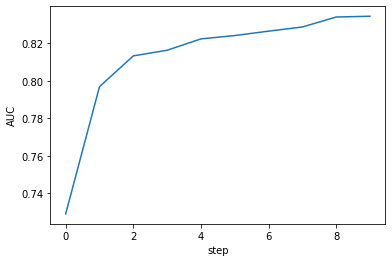

In [8]:
#run pipeline
pline2.run()
pline2.close()

## Training with Multiple Models (Single GPU). 

Now that we have our basic pipeline working we'll probably want to experiment with other architectures. We could try each architecture one-by-one, but if we're working with large data sets this may be prohibitively time consuming. However, with MiniPipe's PipeSystem API we can train and test them all in parallel. We're only restricted by the memory of our GPU and number of physical CPU cores. 

We'll try training four models in parallel. We'll have to make some modifications to our functors. First `gen_fake_data` needs to return four copies of the data, one for each trainer. Second `eval_keras` needs to be a transform, passing the evaluations results (AUCs) to a pipe segment that accumulates them and plots at termination. 

In [9]:
from collections import defaultdict

def gen_fake_data(n_files, rows_per_file, n_cols=32, eps=0.1):
    for _ in range(n_files):
        
        # Generate random features drawn from a standard normal distribution 
        X = np.random.randn(rows_per_file, n_cols)
        
        # Generate binary targets as a non-trivial function of features 
        maximum = X.max(1) - 2.0 # Max of all features less 2 sigma
        interactions = (X*np.flip(X,1)).mean(1) # Pairwise interaction of mirror columns  
        noise = eps*np.random.randn(rows_per_file) # small amount of random noise 
        y = (maximum + interactions + noise >= 0).astype(np.int32)
        
        # Output 4 copies of the data 
        yield (X, y), (X, y), (X, y), (X, y)

class eval_keras:
    
    def __init__(self, X_test, y_test, batch_size, file_name):
        self.batch_size = batch_size
        self.X_test = X_test
        self.y_test = y_test
        self.file_name = file_name
        self.model_name = self.file_name.split('.')[0]
        
    def local_init(self):
        self.epoch = 0
        
        # Ask Tensorflow to use only as much GPU memory as needed
        config = tf.ConfigProto()
        config.gpu_options.allow_growth=True
        sess = tf.Session(config=config)
        
    def run(self, _):
        
        self.model = load_model(self.file_name)
        p = self.model.predict(X_test, batch_size=self.batch_size, verbose=0)
        
        test_auc = auc(y_test, p)
        print('[{0}]Epoch {1}: AUC = {2:0.4f}'.format(self.model_name, self.epoch, test_auc))
        
        self.epoch += 1
        return (self.model_name, test_auc)
    
    
class plot_aucs:
    
    def local_init(self):
        self.auc_dict = defaultdict(list)
        
    def run(self, name_auc_tuple):
        name, test_auc = name_auc_tuple
        self.auc_dict[name].append(test_auc)
    
    def local_term(self):
        for name, aucs in self.auc_dict.items():
            plt.plot(range(len(aucs)), aucs, label=name)
        plt.legend()
        plt.xlabel('step')
        plt.ylabel('AUC')
        plt.title('Model Architecture Search')
        plt.show()

Since this pipeline will have multiple branches we'll need to use the PipeSystem API. In the PipeSystem API we need to define all the Streams explicitly. We'll use a dictionary to store all the model architectures and names. If we want to add more models we can simply expand this dictionary. 

In [10]:
# Init generator (optional) and class functors
loader = gen_fake_data(n_files=10, rows_per_file=32*1000)

# Define hidden architectures
archs = {'keras-16':[16],
         'keras-32-16':[32,16],
         'keras-64-32-16':[64,32,16],
         'keras-128-64-32-16':[128,64,32,16]}

# Define trainer fuctors 
trainers = [train_keras(hidden_arch=arch, batch_size=32, save_name=name+'.hdf5') 
            for name, arch in archs.items()]

# Generate one set of test data
(X_test, y_test), *_ = next(gen_fake_data(n_files=1, rows_per_file=32*1000))

# Define evaluator functors with same test set
evaluators = [eval_keras(X_test, y_test, batch_size=128, file_name = name+'.hdf5') 
              for name in archs.keys()]

# Define Streams
train_streams = [mp.Stream() for _ in range(len(archs))]
eval_streams = [mp.Stream() for _ in range(len(archs))]
s_plt = mp.Stream()

# Define pipe segments (order does not matter)
pipes = [mp.Source(loader, downstreams=train_streams, name='Loader')]

pipes += [mp.Transform(trnr, upstreams=[s_tr], downstreams=[s_evl], name='Train{}'.format(i))
         for i, (trnr, s_tr, s_evl) in enumerate(zip(trainers, train_streams, eval_streams))]

pipes += [mp.Transform(evlr, upstreams=[s_evl], downstreams=[s_plt], name='Eval{}'.format(i)) 
         for i , (evlr, s_evl) in enumerate(zip(evaluators, eval_streams))]

pipes += [mp.Sink(plot_aucs(), upstreams=[s_plt], name='Plot')]


Now when we build the pipeline we just need to supply `PipeSystem` with a list of pipe segments. 

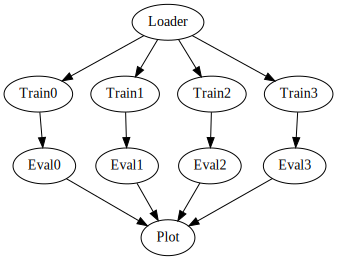

In [11]:
# Build and display pipe system
psys = mp.PipeSystem(pipes)
psys.build() 
psys.diagram()

[keras-16]Epoch 0: AUC = 0.6793
[keras-32-16]Epoch 0: AUC = 0.6928
[keras-64-32-16]Epoch 0: AUC = 0.7498
[keras-128-64-32-16]Epoch 0: AUC = 0.7930
[keras-16]Epoch 1: AUC = 0.7054
[keras-32-16]Epoch 1: AUC = 0.7475
[keras-64-32-16]Epoch 1: AUC = 0.8080
[keras-16]Epoch 2: AUC = 0.7244
[keras-128-64-32-16]Epoch 1: AUC = 0.8192
[keras-32-16]Epoch 2: AUC = 0.7843
[keras-64-32-16]Epoch 2: AUC = 0.8212
[keras-16]Epoch 3: AUC = 0.7391
[keras-128-64-32-16]Epoch 2: AUC = 0.8272
[keras-32-16]Epoch 3: AUC = 0.8035
[keras-16]Epoch 4: AUC = 0.7470
[keras-64-32-16]Epoch 3: AUC = 0.8234
[keras-32-16]Epoch 4: AUC = 0.8136
[keras-128-64-32-16]Epoch 3: AUC = 0.8311
[keras-16]Epoch 5: AUC = 0.7526
[keras-64-32-16]Epoch 4: AUC = 0.8287
[keras-32-16]Epoch 5: AUC = 0.8181
[keras-16]Epoch 6: AUC = 0.7561
[keras-128-64-32-16]Epoch 4: AUC = 0.8388
[keras-64-32-16]Epoch 5: AUC = 0.8301


2020-01-05 20:01:00,984 - INFO - Loader - End of stream


[keras-32-16]Epoch 6: AUC = 0.8201
[keras-16]Epoch 7: AUC = 0.7563
[keras-128-64-32-16]Epoch 5: AUC = 0.8475
[keras-64-32-16]Epoch 6: AUC = 0.8338
[keras-16]Epoch 8: AUC = 0.7567
[keras-32-16]Epoch 7: AUC = 0.8187


2020-01-05 20:01:06,157 - INFO - Train0 - Local termination


[keras-128-64-32-16]Epoch 6: AUC = 0.8554
[keras-16]Epoch 9: AUC = 0.7599


2020-01-05 20:01:08,238 - INFO - Eval0 - Local termination


[keras-64-32-16]Epoch 7: AUC = 0.8341
[keras-32-16]Epoch 8: AUC = 0.8205


2020-01-05 20:01:10,113 - INFO - Train1 - Local termination


[keras-128-64-32-16]Epoch 7: AUC = 0.8612
[keras-32-16]Epoch 9: AUC = 0.8253


2020-01-05 20:01:12,503 - INFO - Eval1 - Local termination


[keras-64-32-16]Epoch 8: AUC = 0.8360


2020-01-05 20:01:14,155 - INFO - Train2 - Local termination


[keras-64-32-16]Epoch 9: AUC = 0.8445


2020-01-05 20:01:16,512 - INFO - Eval2 - Local termination


[keras-128-64-32-16]Epoch 8: AUC = 0.8671


2020-01-05 20:01:19,034 - INFO - Train3 - Local termination
2020-01-05 20:01:19,034 - INFO - Loader - Local termination


[keras-128-64-32-16]Epoch 9: AUC = 0.8822


2020-01-05 20:01:21,564 - INFO - Eval3 - Local termination
2020-01-05 20:01:21,565 - INFO - Plot - Local termination


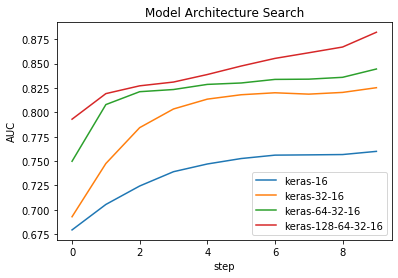

In [12]:
psys.run()
psys.close()

## Time Comparisons

Now lets do a time comparison between our three different pipelines. Pipelines need to be reset before they can be run again. 

In [17]:
pline.reset()
pline2.reset()
psys.reset()

We'll use Jupyter's %%timeit magic cell to time a single iteration of each. 

In [18]:
%%timeit -n 1 -r 1
pline.run()
pline.close()

Model Summary
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 3,169
Trainable params: 3,169
Non-trainable params: 0
_________________________________________________________________

Epoch 1/1
32000/32000 [==============================] - 5s 169us/step - loss: 0.6436 - acc: 0.6197
Epoch 1/1
32000/32000 [==============================] - 5s 142us/step - loss: 0.5764 - acc: 0.6952
Epoch 1/1
32000/32000 [==============================] - 5s 144us/step - loss: 0.5332 - acc: 0.7270
Epoch 1/1
32000/32000 [==============================] - 5s 145us/step - loss: 0.5192 - a

2020-01-05 20:11:18,448 - INFO - loader - End of stream


32000/32000 [==============================] - 5s 145us/step - loss: 0.5075 - acc: 0.7452
Epoch 1/1


2020-01-05 20:11:23,102 - INFO - loader - Local termination


32000/32000 [==============================] - 5s 143us/step - loss: 0.5086 - acc: 0.7430
Epoch 1/1
32000/32000 [==============================] - 5s 144us/step - loss: 0.4971 - acc: 0.7523
Epoch 1/1
32000/32000 [==============================] - 5s 145us/step - loss: 0.5003 - acc: 0.7504


2020-01-05 20:11:36,937 - INFO - trainer - Local termination


Saving model to keras_model.hdf5
47.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


The simple pipeline takes 48s on my machine. We'll use that as our baseline.  

Epoch 0: AUC = 0.7261
Epoch 1: AUC = 0.7941
Epoch 2: AUC = 0.8129
Epoch 3: AUC = 0.8190
Epoch 4: AUC = 0.8226


2020-01-05 20:12:15,862 - INFO - loader - End of stream


Epoch 5: AUC = 0.8255


2020-01-05 20:12:20,015 - INFO - loader - Local termination


Epoch 6: AUC = 0.8285
Epoch 7: AUC = 0.8282
Epoch 8: AUC = 0.8278


2020-01-05 20:12:32,371 - INFO - trianer - Local termination


Epoch 9: AUC = 0.8368


2020-01-05 20:12:34,041 - INFO - evaluator - Local termination


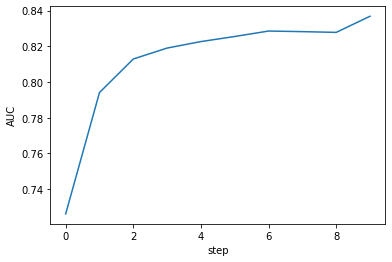

45.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [19]:
%%timeit -n 1 -r 1
pline2.run()
pline2.close()

Wow! The pipeline with test set evaluation roughly the same amount of time. This is because prediction and AUC calcualtion all happen durning training. As long as these other task take less time than training we shouldn't expect any slowdown. 

[keras-16]Epoch 0: AUC = 0.6793
[keras-32-16]Epoch 0: AUC = 0.6928
[keras-64-32-16]Epoch 0: AUC = 0.7498
[keras-128-64-32-16]Epoch 0: AUC = 0.7930
[keras-16]Epoch 1: AUC = 0.7054
[keras-32-16]Epoch 1: AUC = 0.7476
[keras-64-32-16]Epoch 1: AUC = 0.8080
[keras-16]Epoch 2: AUC = 0.7244
[keras-128-64-32-16]Epoch 1: AUC = 0.8192
[keras-32-16]Epoch 2: AUC = 0.7845
[keras-64-32-16]Epoch 2: AUC = 0.8212
[keras-16]Epoch 3: AUC = 0.7391
[keras-128-64-32-16]Epoch 2: AUC = 0.8272
[keras-32-16]Epoch 3: AUC = 0.8035
[keras-16]Epoch 4: AUC = 0.7470
[keras-64-32-16]Epoch 3: AUC = 0.8234
[keras-32-16]Epoch 4: AUC = 0.8134
[keras-128-64-32-16]Epoch 3: AUC = 0.8311
[keras-16]Epoch 5: AUC = 0.7526
[keras-64-32-16]Epoch 4: AUC = 0.8287
[keras-32-16]Epoch 5: AUC = 0.8179
[keras-16]Epoch 6: AUC = 0.7561
[keras-128-64-32-16]Epoch 4: AUC = 0.8388
[keras-64-32-16]Epoch 5: AUC = 0.8301


2020-01-05 20:13:51,022 - INFO - Loader - End of stream


[keras-32-16]Epoch 6: AUC = 0.8203
[keras-16]Epoch 7: AUC = 0.7563
[keras-128-64-32-16]Epoch 5: AUC = 0.8475
[keras-64-32-16]Epoch 6: AUC = 0.8338
[keras-16]Epoch 8: AUC = 0.7567
[keras-32-16]Epoch 7: AUC = 0.8186


2020-01-05 20:13:56,442 - INFO - Train0 - Local termination


[keras-128-64-32-16]Epoch 6: AUC = 0.8554
[keras-16]Epoch 9: AUC = 0.7599


2020-01-05 20:13:58,527 - INFO - Eval0 - Local termination


[keras-64-32-16]Epoch 7: AUC = 0.8341
[keras-32-16]Epoch 8: AUC = 0.8204


2020-01-05 20:14:00,351 - INFO - Train1 - Local termination


[keras-128-64-32-16]Epoch 7: AUC = 0.8612
[keras-32-16]Epoch 9: AUC = 0.8253


2020-01-05 20:14:02,569 - INFO - Eval1 - Local termination


[keras-64-32-16]Epoch 8: AUC = 0.8360


2020-01-05 20:14:04,427 - INFO - Train2 - Local termination


[keras-128-64-32-16]Epoch 8: AUC = 0.8671
[keras-64-32-16]Epoch 9: AUC = 0.8445


2020-01-05 20:14:06,983 - INFO - Eval2 - Local termination
2020-01-05 20:14:08,950 - INFO - Loader - Local termination
2020-01-05 20:14:08,950 - INFO - Train3 - Local termination


[keras-128-64-32-16]Epoch 9: AUC = 0.8822


2020-01-05 20:14:11,234 - INFO - Eval3 - Local termination
2020-01-05 20:14:11,236 - INFO - Plot - Local termination


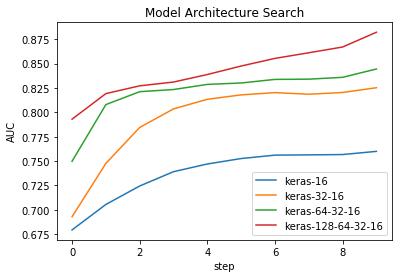

49.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [20]:
%%timeit -n 1 -r 1
psys.run()
psys.close()

Training four models only takes an additional few seconds! In fact this additional time can be contributed to the larger network architecture (keras-128-64-32-16). This model has more weights and thus takes longer to train. The pipeline is only has fast as it's slowest component, so it has to wait untill all models finish training before it terminates. We can see from the logs that keras-128-64-32-16 (Train3/Eval3)is indeed that last to terminate. 